In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# 1. Загрузка данных строго по методичке
df_cheaters = pd.read_csv('Cheaters.csv')
df_cash = pd.read_csv('Cash.csv')
df_money = pd.read_csv('Money.csv')
df_platforms = pd.read_csv('Platforms.csv').drop_duplicates()  # Добавлено удаление дубликатов
df_ab = pd.read_csv('ABgroup.csv').drop_duplicates()  # Добавлено удаление дубликатов

# 2. Фильтрация читеров (строго по методичке)
true_cheaters = df_cheaters[df_cheaters['cheaters'] == 1]
df_money_nocheaters = df_money[~df_money['user_id'].isin(true_cheaters['user_id'])]


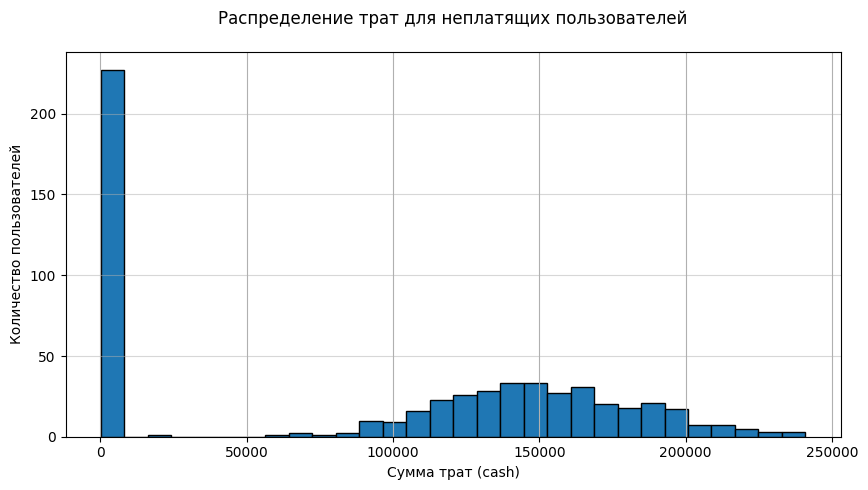

In [2]:
# 3. Поиск скрытых читеров (как в методичке)
df_group_money = df_money_nocheaters.groupby('user_id')['money'].sum().reset_index()
df_group_cash = df_cash.groupby('user_id')['cash'].sum().reset_index()
df_cash_money = pd.merge(df_group_money, df_group_cash, on='user_id', how='inner')
df_non_payers = df_cash_money[df_cash_money['money'] == 0]

# Визуализация распределения (как в методичке)
plt.figure(figsize=(10, 5))
df_non_payers['cash'].hist(bins=30, edgecolor='black')
plt.title('Распределение трат для неплатящих пользователей', pad=20)
plt.xlabel('Сумма трат (cash)')
plt.ylabel('Количество пользователей')
plt.grid(axis='y', alpha=0.5)
plt.show()

In [3]:
# 4. Определение порога для читеров (как в методичке)
df_true_cheaters = df_non_payers[df_non_payers['cash'] >= 50000]
all_cheaters = list(set(true_cheaters['user_id']).union(set(df_true_cheaters['user_id'])))

# 5. Функция для анализа A/B теста (адаптировано под требования)
def run_ab_test(platform_name):
    # Фильтрация по платформе и удаление читеров
    df_platform = df_platforms[df_platforms['platform'] == platform_name]
    df_platform_clean = df_platform[~df_platform['user_id'].isin(all_cheaters)]

    # Объединение данных строго по методичке
    df_platform_money = pd.merge(df_platform_clean, df_money, on='user_id')
    df_platform_ab = pd.merge(df_platform_money, df_ab, on='user_id')

    # Разделение на группы
    test = df_platform_ab[df_platform_ab['group'] == 'test']
    control = df_platform_ab[df_platform_ab['group'] == 'control']

    # Расчет метрик ARPU (как в методичке)
    arpu_test = test['money'].sum() / test['user_id'].nunique()
    arpu_control = control['money'].sum() / control['user_id'].nunique()

    # Доверительные интервалы (как в методичке)
    def get_ci(data, confidence=0.95):
        n = len(data)
        mean, se = np.mean(data), stats.sem(data)
        h = se * stats.t.ppf((1 + confidence)/2, n-1)
        return mean, mean-h, mean+h

    test_ci = get_ci(test.groupby('user_id')['money'].sum())
    control_ci = get_ci(control.groupby('user_id')['money'].sum())

    # Проверка пересечения интервалов
    has_significant_diff = test_ci[1] > control_ci[2] or test_ci[2] < control_ci[1]

    # Расчет ARPPU (дополнение к методичке)
    arppu_test = test[test['money'] > 0]['money'].mean() if len(test[test['money'] > 0]) > 0 else 0
    arppu_control = control[control['money'] > 0]['money'].mean() if len(control[control['money'] > 0]) > 0 else 0

    return {
        'platform': platform_name,
        'arpu_test': arpu_test,
        'arpu_control': arpu_control,
        'test_ci': test_ci,
        'control_ci': control_ci,
        'is_significant': has_significant_diff,
        'arppu_test': arppu_test,
        'arppu_control': arppu_control,
        'test_users': test['user_id'].nunique(),
        'control_users': control['user_id'].nunique()
    }


In [4]:
# 6. Запуск анализа для всех платформ (PC, PS4, Xbox)
results = []
for platform in ['PC', 'PS4', 'Xbox']:
    platform_results = run_ab_test(platform)
    results.append(platform_results)

# 7. Форматирование результатов (как требовалось)
results_df = pd.DataFrame(results)

# 8. Вывод результатов в требуемом формате
print("\n" + "="*50)
print("Результаты A/B тестирования по платформам")
print("="*50 + "\n")

for _, row in results_df.iterrows():
    print(f"Платформа: {row['platform']}")
    print(f"ARPU тест: {row['arpu_test']:.2f} (95% ДИ: [{row['test_ci'][1]:.2f}, {row['test_ci'][2]:.2f}])")
    print(f"ARPU контроль: {row['arpu_control']:.2f} (95% ДИ: [{row['control_ci'][1]:.2f}, {row['control_ci'][2]:.2f}])")
    print(f"Статистически значимая разница: {'Да' if row['is_significant'] else 'Нет'}")
    print(f"ARPPU тест: {row['arppu_test']:.2f}")
    print(f"ARPPU контроль: {row['arppu_control']:.2f}")
    print(f"Пользователей: тест={row['test_users']}, контроль={row['control_users']}")
    print("-"*50 + "\n")


Результаты A/B тестирования по платформам

Платформа: PC
ARPU тест: 6.27 (95% ДИ: [6.26, 6.28])
ARPU контроль: 5.65 (95% ДИ: [5.64, 5.65])
Статистически значимая разница: Да
ARPPU тест: 1.31
ARPPU контроль: 1.26
Пользователей: тест=179820, контроль=179733
--------------------------------------------------

Платформа: PS4
ARPU тест: 6.08 (95% ДИ: [6.08, 6.09])
ARPU контроль: 5.74 (95% ДИ: [5.73, 5.75])
Статистически значимая разница: Да
ARPPU тест: 1.30
ARPPU контроль: 1.27
Пользователей: тест=179415, контроль=179804
--------------------------------------------------

Платформа: Xbox
ARPU тест: nan (95% ДИ: [nan, nan])
ARPU контроль: nan (95% ДИ: [nan, nan])
Статистически значимая разница: Нет
ARPPU тест: 0.00
ARPPU контроль: 0.00
Пользователей: тест=0, контроль=0
--------------------------------------------------



<ipython-input-3-ece554bceb63>:20: RuntimeWarning: invalid value encountered in scalar divide
  arpu_test = test['money'].sum() / test['user_id'].nunique()
<ipython-input-3-ece554bceb63>:21: RuntimeWarning: invalid value encountered in scalar divide
  arpu_control = control['money'].sum() / control['user_id'].nunique()
<ipython-input-3-ece554bceb63>:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  mean, se = np.mean(data), stats.sem(data)
<ipython-input-3-ece554bceb63>:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  mean, se = np.mean(data), stats.sem(data)


In [5]:
# 9. Сохранение результатов в Excel (дополнительно)
output_columns = [
    'platform', 'arpu_test', 'arpu_control',
    'is_significant', 'arppu_test', 'arppu_control',
    'test_users', 'control_users'
]
results_df[output_columns].to_excel('ab_test_results_final.xlsx', index=False)

print("Результаты сохранены в файл 'ab_test_results_final.xlsx'")

Результаты сохранены в файл 'ab_test_results_final.xlsx'


In [6]:
# 10. Создание сводной таблицы
def create_summary_table(results_df):
    # Преобразуем доверительные интервалы в читаемый формат
    results_df['test_ci_str'] = results_df['test_ci'].apply(
        lambda x: f"[{x[1]:.2f}, {x[2]:.2f}]")
    results_df['control_ci_str'] = results_df['control_ci'].apply(
        lambda x: f"[{x[1]:.2f}, {x[2]:.2f}]")

    # Рассчитываем разницу в процентах
    results_df['arpu_diff_pct'] = round(
        (results_df['arpu_test'] - results_df['arpu_control']) / results_df['arpu_control'] * 100, 1)
    results_df['arppu_diff_pct'] = round(
        (results_df['arppu_test'] - results_df['arppu_control']) / results_df['arppu_control'] * 100, 1)

    # Создаем сводную таблицу
    summary_table = pd.DataFrame({
        'Платформа': results_df['platform'],
        'Пользователей (тест)': results_df['test_users'],
        'Пользователей (контроль)': results_df['control_users'],
        'ARPU тест': round(results_df['arpu_test'], 2),
        'ARPU контроль': round(results_df['arpu_control'], 2),
        'Разница ARPU (%)': results_df['arpu_diff_pct'],
        'ДИ ARPU тест': results_df['test_ci_str'],
        'ДИ ARPU контроль': results_df['control_ci_str'],
        'ARPPU тест': round(results_df['arppu_test'], 2),
        'ARPPU контроль': round(results_df['arppu_control'], 2),
        'Разница ARPPU (%)': results_df['arppu_diff_pct'],
        'Стат. значимость': results_df['is_significant'].map({True: 'Да', False: 'Нет'})
    })

    # Переупорядочиваем столбцы для лучшей читаемости
    column_order = [
        'Платформа',
        'Пользователей (тест)', 'Пользователей (контроль)',
        'ARPU тест', 'ARPU контроль', 'Разница ARPU (%)',
        'ДИ ARPU тест', 'ДИ ARPU контроль',
        'ARPPU тест', 'ARPPU контроль', 'Разница ARPPU (%)',
        'Стат. значимость'
    ]

    return summary_table[column_order]

# Создаем и выводим сводную таблицу
summary_table = create_summary_table(results_df)
print("\nСводная таблица результатов A/B теста:")
display(summary_table)

# Сохраняем сводную таблицу в Excel
summary_table.to_excel('ab_test_summary_table.xlsx', index=False)
print("\nСводная таблица сохранена в файл 'ab_test_summary_table.xlsx'")

# Дополнительно: сохраняем в один файл на разных листах
with pd.ExcelWriter('ab_test_full_results.xlsx') as writer:
    results_df[output_columns].to_excel(writer, sheet_name='Детальные результаты', index=False)
    summary_table.to_excel(writer, sheet_name='Сводная таблица', index=False)
print("Полные результаты сохранены в файл 'ab_test_full_results.xlsx'")


Сводная таблица результатов A/B теста:


Платформа  Пользователей (тест)  Пользователей (контроль)  ARPU тест  \
0        PC                179820                    179733       6.27   
1       PS4                179415                    179804       6.08   
2      Xbox                     0                         0        NaN   

   ARPU контроль  Разница ARPU (%)  ДИ ARPU тест ДИ ARPU контроль  ARPPU тест  \
0           5.65              11.0  [6.26, 6.28]     [5.64, 5.65]        1.31   
1           5.74               6.1  [6.08, 6.09]     [5.73, 5.75]        1.30   
2            NaN               NaN    [nan, nan]       [nan, nan]        0.00   

   ARPPU контроль  Разница ARPPU (%) Стат. значимость  
0            1.26                3.5               Да  
1            1.27                1.8               Да  
2            0.00                NaN              Нет


Сводная таблица сохранена в файл 'ab_test_summary_table.xlsx'
Полные результаты сохранены в файл 'ab_test_full_results.xlsx'
